# MACE in Practice II

In this tutorial, you will learn how to improve MLIP models by using iterative training and active learning. We illustrate these training workflows on MACE, but they are broadly applicable to all MLIPs. We will also showcase the state-of-the-art [foundational models](https://matbench-discovery.materialsproject.org/) - the latest development in the field of MLIPs. These models are trained on massive training sets of [inorganic](https://doi.org/10.48550/arXiv.2401.00096) and [organic](https://doi.org/10.48550/arXiv.2312.15211) databases and show a great deal of `out-of-the-box` MD stability in an extensive variety of [applications](https://doi.org/10.48550/arXiv.2401.00096). We will discuss [fine-tunning](https://doi.org/10.48550/arXiv.2405.20217) which is an actively-researched technique to tweak these foundational models to new systems (out of training) and/or new levels of reference theory.

## Learning Objectives for today:

1. **Iterative Training: improving stability and accuracy**
2. **Error estimation: committee models**
3. **Active learning: unsupervised iterative training**
4. **Foundational models: out-of-the-box MLIPs**
5. **Fine-tuning on new data and labels**

## 1. Iterative Training

### 1.1 MD with a smaller MACE model

The model we trained in our previous tutorial was already stable in MD and quite accurate with little training. This is both because MACE models are smooth and regular (combining lessons from 10-15 years of MLIP development) but also because the task of simulating a single molecule for a few picoseconds is not so difficult. In general, in real research applications, achieving MD stability and then accuracy is not always so straightforward. Models are usually improved through iterative training and active learning which expands the training data to fix errors on the model potential energy surface. To illustrate these concepts in practice, let's first train a less accurate and stable MACE by reducing the model size and amount of training data:

In [37]:
db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_xtb_train_50.xyz', db[:53]) #first 50 configs plus the 3 E0s

!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com1" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.10 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=50 \
    --swa \
    --seed=123

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*_run-*.model"):
    os.remove(file)
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

2024-07-21 23:19:07.167 INFO: MACE version: 0.3.6
2024-07-21 23:19:07.167 INFO: Configuration: Namespace(config=None, name='mace02_com1', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=2, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/solvent_xtb_train_50.xyz', valid_file=None, valid_fraction=0.

Notice, we are getting substantially larger errors than before. Now, let's run some dynamics:

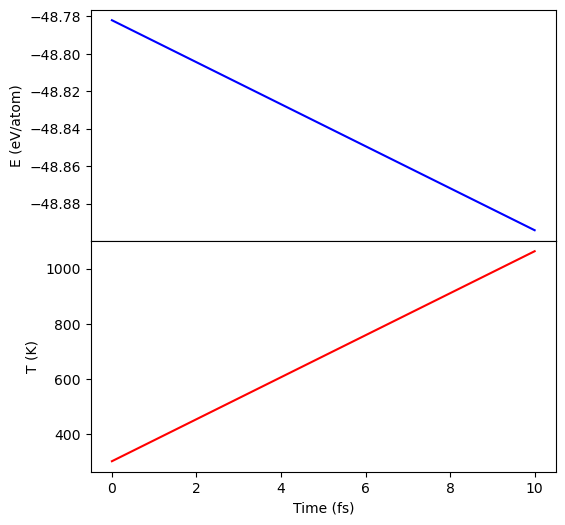

KeyboardInterrupt: 

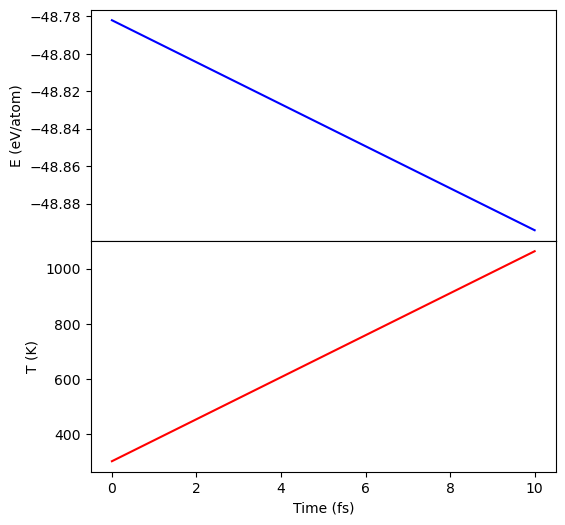

In [61]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    np.random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

#let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['MACE_models/mace02_com1_swa_compiled.model'], device='cuda', default_dtype="float32")

simpleMD(init_conf, temp=1200, calc=mace_calc, fname='moldyn/mace02_md.xyz', s=10, T=2000)

![alt text](figures/iterative_training.png)

# Active Learning with MACE

![alt text](figures/active_learning.png)


This is a short tutorial on how to use active learning with MACE.

Active learning consists is an iterative fitting process aiming at providing the model with the most optimal training data for increasing its performance. For any active learning sheme, two things are essential:

- A efficient data generation source, in our case molecular dynamics.
- A score function rating the utility of a given data to be trained

The score function in the case of interatomic potentials is usually correlated to the uncertainty of the prediction of the model for a given configuration. For neural networks potentials like MACE, a straightforward measure of uncertainty is the variance of the output over an ensemble of models.


To obtain a comittee from MACE, we need to train a committee of models and add some randomness to the optimization process. We can achieve this by changing the `--seed`.

Let us train three small MACE models to make sure they break for demo purposes. We will use different seeds for the three independent models. This will allow us to create a `comittee` of independent predictors. As we change hyper parameters, we will also change the `--name` of the model to make sure it saves seperatly.

In [40]:
!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com2" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.10 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=50 \
    --swa \
    --seed=345

!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com3" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.10 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=50 \
    --swa \
    --seed=567

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*_run-*.model"):
    os.remove(file)
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

2024-07-21 23:27:55.128 INFO: MACE version: 0.3.6
2024-07-21 23:27:55.129 INFO: Configuration: Namespace(config=None, name='mace02_com2', seed=345, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=2, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/solvent_xtb_train_50.xyz', valid_file=None, valid_fraction=0.

In [ ]:
#prepare a much smaller training example, and let us pick independent data sets
from ase.io import read, write
db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_mace_small1_train.xyz', db[:3]+db[3:53]) #
write('data/solvent_mace_small2_train.xyz', db[:3]+db[53:103])
write('data/solvent_mace_small3_train.xyz', db[:3]+db[103:153])

#train the first model
!python3 ./mace/scripts/run_train.py \
    --name="model_small1" \
    --train_file="data/solvent_mace_small1_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cuda \
    --seed=345

#train the second model
!python3 ./mace/scripts/run_train.py \
    --name="model_small2" \
    --train_file="data/solvent_mace_small2_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cuda \
    --seed=567

#train the thirds model
!python3 ./mace/scripts/run_train.py \
    --name="model_small3" \
    --train_file="data/solvent_mace_small3_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cuda \
    --seed=731

Now we can run dynamics with a commitee of models and look at the variance in the energy prediction. Because XTB is cheap enough we can compare that variance with the true error. Do they correlate?

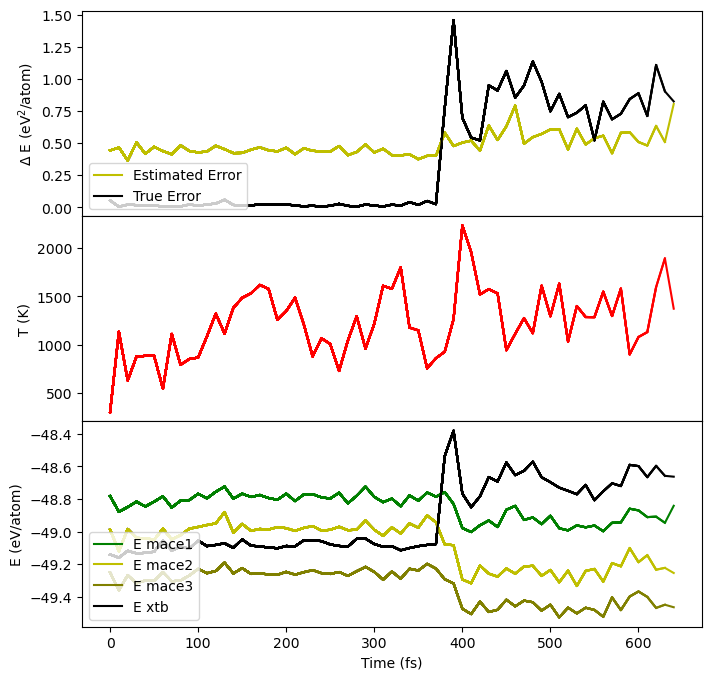

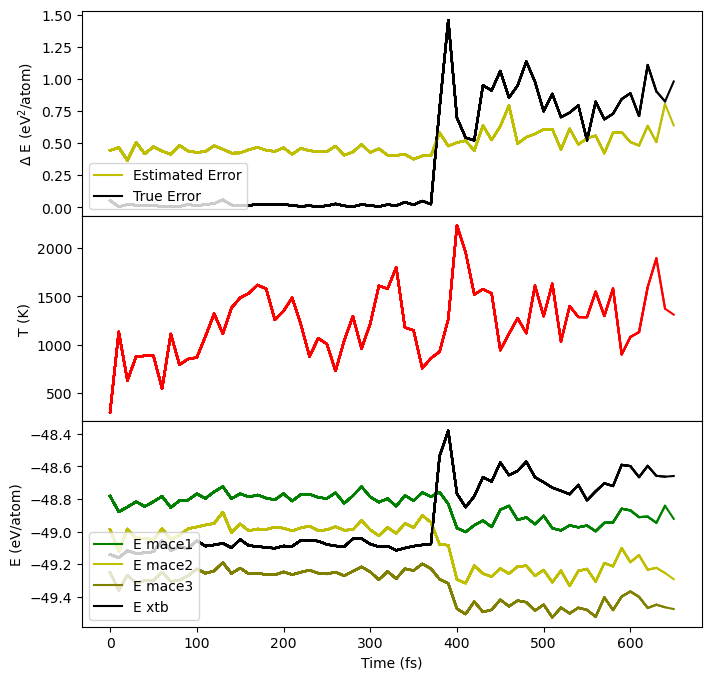

KeyboardInterrupt: 

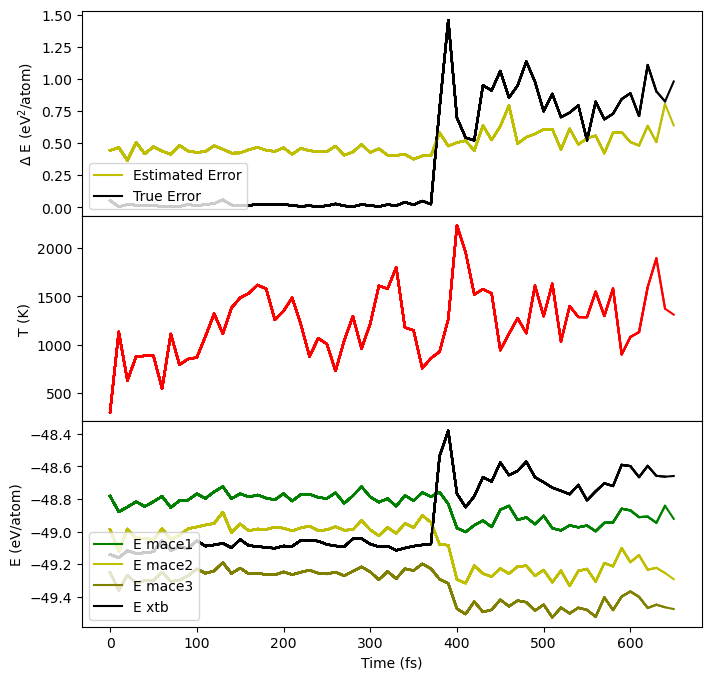

In [1]:
from aseMolec import extAtoms as ea
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
from ase.io import read, write

import random
import numpy as np
import time
import pylab as pl
from IPython import display

from xtb.ase.calculator import XTB
from mace.calculators import MACECalculator

model_paths = ['MACE_models/mace02_com1_swa_compiled.model',
               'MACE_models/mace02_com2_swa_compiled.model',
               'MACE_models/mace02_com3_swa_compiled.model']
xtb_calc = XTB(method="GFN2-xTB")
mace_calc = MACECalculator(model_paths=model_paths, device='cuda', default_dtype="float32")

init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
init_conf.calc = mace_calc

#initialize the temperature
np.random.seed(701)
MaxwellBoltzmannDistribution(init_conf, temperature_K=300)
Stationary(init_conf)
ZeroRotation(init_conf)

dyn = Langevin(init_conf, 1*units.fs, temperature_K=1200, friction=0.1)

%matplotlib inline

time_fs = []
temperature = []
energies_1 = []
energies_2 = []
energies_3 = []
variances = []
xtb_energies = []
true_errors = []

! rm -rfv committee_md.xyz
fig, ax = pl.subplots(3, 1, figsize=(8,8), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})


def write_frame():
        at = dyn.atoms.copy()
        at.calc = xtb_calc
        xtb_energy = at.get_potential_energy()

        dyn.atoms.write('committee_md.xyz', append=True, write_results=False)
        time_fs.append(dyn.get_time()/units.fs)
        temperature.append(dyn.atoms.get_temperature())
        energies_1.append(dyn.atoms.calc.results["energies"][0]/len(dyn.atoms))
        energies_2.append(dyn.atoms.calc.results["energies"][1]/len(dyn.atoms))
        energies_3.append(dyn.atoms.calc.results["energies"][2]/len(dyn.atoms))
        variances.append(dyn.atoms.calc.results["energy_var"]/len(dyn.atoms))
        xtb_energies.append(xtb_energy/len(dyn.atoms))
        true_errors.append(np.var([dyn.atoms.calc.results["energy"],xtb_energy])/len(dyn.atoms))

        # subplot the variance of the energy as a function of the steps and the temperature as two subplots
        ax[0].plot(np.array(time_fs), np.array(variances), color="y")
        ax[0].plot(np.array(time_fs), np.array(true_errors), color="black")
        ax[0].set_ylabel(r'$\Delta$ E (eV$^2$/atom)')
        ax[0].legend(['Estimated Error', 'True Error'], loc='lower left')

        # plot the temperature of the system as subplots
        ax[1].plot(np.array(time_fs), temperature, color="r", label='Temperature')
        ax[1].set_ylabel("T (K)")

        ax[2].plot(np.array(time_fs), energies_1, color="g")
        ax[2].plot(np.array(time_fs), energies_2, color="y")
        ax[2].plot(np.array(time_fs), energies_3, color="olive")
        ax[2].plot(np.array(time_fs), xtb_energies, color="black")
        ax[2].set_ylabel("E (eV/atom)")
        ax[2].set_xlabel('Time (fs)')
        ax[2].legend(['E mace1', 'E mace2', 'E mace3', 'E xtb'], loc='lower left')

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.01)

dyn.attach(write_frame, interval=10)
dyn.run(2000)
print("MD finished!")

As expected, the dynamics has failed. In this case our reference PES is xtb which is cheap to evaluate so we can easily check the error on the fly. In practice we will be trainking MLIPs on expensive reference methods, where computing the true error on the fly is impractical. Notice when the dynamics `explodes`, the `true error` divergese, but crucially the `estimated error` also diverges.